In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/image_classification

/content/drive/My Drive/image_classification


In [ ]:
%ls

food_image_classification_model.ipynb  model_test/   train_set/
image_classification.h5                test_set/     train_set.zip
mobilenetv2_tuned.h5                   test_set.zip  Untitled0.ipynb


In [ ]:
!unzip '/content/drive/My Drive/image_classification/test_set.zip' -d '/content/drive/My Drive/image_classification/test_set'

Archive:  /content/drive/My Drive/image_classification/test_set.zip
replace /content/drive/My Drive/image_classification/test_set/baby_back_ribs/2854197.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip '/content/drive/My Drive/image_classification/train_set.zip' -d '/content/drive/My Drive/image_classification/train_set'

Archive:  /content/drive/My Drive/image_classification/train_set.zip
replace /content/drive/My Drive/image_classification/train_set/baby_back_ribs/2347150.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
from datetime import datetime
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        shear_range=0.3,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.25,
)
valid_datagen = ImageDataGenerator(
        rescale=1./255,
)

In [ ]:
batch_size = 64
img_width = 128
img_height = 128

train_data = train_datagen.flow_from_directory(
    './train_set/',
    batch_size=batch_size,
    target_size=(img_width, img_height),
    shuffle=True,
)
valid_data = valid_datagen.flow_from_directory(
    './test_set/',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False,
)

Found 1500 images belonging to 6 classes.
Found 300 images belonging to 6 classes.


In [ ]:
classes = list(train_data.class_indices.keys())
classes

['baby_back_ribs',
 'bibimbap',
 'club_sandwich',
 'grilled_salmon',
 'hot_dog',
 'steak']

In [ ]:
def visualize_images(images, labels):
    figure, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 14))
    classes = list(train_data.class_indices.keys())
    img_no = 0
    for i in range(3):
        for j in range(3):
            img = images[img_no]
            label_no = np.argmax(labels[img_no])
            
            ax[i,j].imshow(img)
            ax[i,j].set_title(classes[label_no])
            ax[i,j].set_axis_off()
            img_no += 1

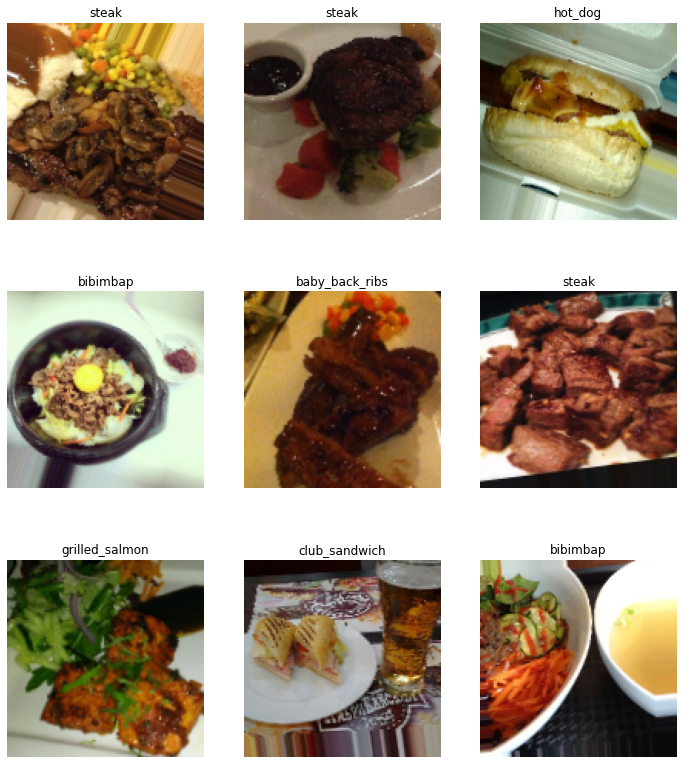

In [ ]:
images, labels = next(train_data)
visualize_images(images, labels)

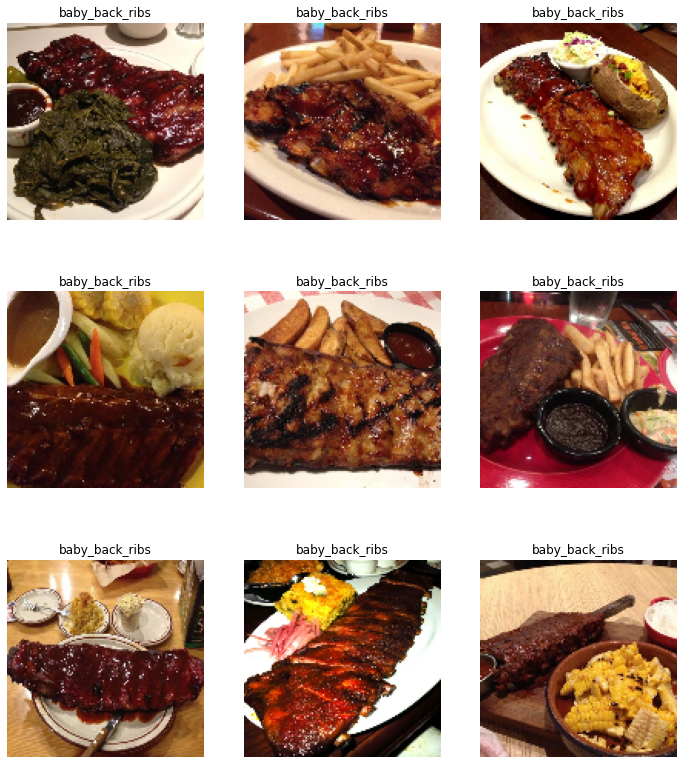

In [ ]:
images, labels = next(valid_data)
visualize_images(images, labels)

In [ ]:
base = MobileNetV2(input_shape=(img_width, img_height,3),include_top=False,weights='imagenet')
base.trainable = True
model = Sequential()
model.add(base)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss = 'categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 2,422,726
Trainable params: 2,388,614
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 1,verbose = 1)
early_stop = EarlyStopping(monitor = 'val_accuracy',patience = 5,verbose = 1,restore_best_weights = True)
check_point = ModelCheckpoint('best_model.h5',monitor='val_accuracy',verbose=1,save_best_only=True)

In [ ]:
history = model.fit(train_data, epochs=50, validation_data = valid_data, callbacks=[early_stop,reduce_lr,check_point])

Epoch 1/50
24/24 [==============================] - 103s 4s/step - loss: 0.4349 - accuracy: 0.8573 - val_loss: 0.9107 - val_accuracy: 0.7533

Epoch 00001: val_accuracy improved from -inf to 0.75333, saving model to mobilenetv2_3_tuned.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
24/24 [==============================] - 102s 4s/step - loss: 0.4090 - accuracy: 0.8613 - val_loss: 0.8993 - val_accuracy: 0.7533

Epoch 00002: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.

Epoch 00002: val_accuracy did not improve from 0.75333
Epoch 3/50
24/24 [==============================] - 103s 4s/step - loss: 0.4347 - accuracy: 0.8687 - val_loss: 0.8876 - val_accuracy: 0.7533

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.

Epoch 00003: val_accuracy did not improve from 0.75333
Epoch 4/50
24/24 [==============================] - 103s 4s/step - loss: 0.4308 - accuracy: 0.8487 - val_loss: 0.8762 - val_accuracy: 0.7667

Epoch 00004: val_accuracy improved from 0.75333 to 0.76667, saving model to mobilenetv2_3_tuned.h5
Epoch 5/50
24/24 [==============================] - 103s 4s/step - loss: 0.4393 - accuracy: 0.8487 - val_loss: 0.8655 - val_accuracy: 0.7667

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.00